# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [39]:
# Install the required libraries
!pip install prophet

In [40]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [41]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

/var/folders/yg/wczv5tr14310nbkhj3m8dkkh0000gn/T/ipykernel_96896/1669825240.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [42]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


<Figure size 900x1200 with 0 Axes>

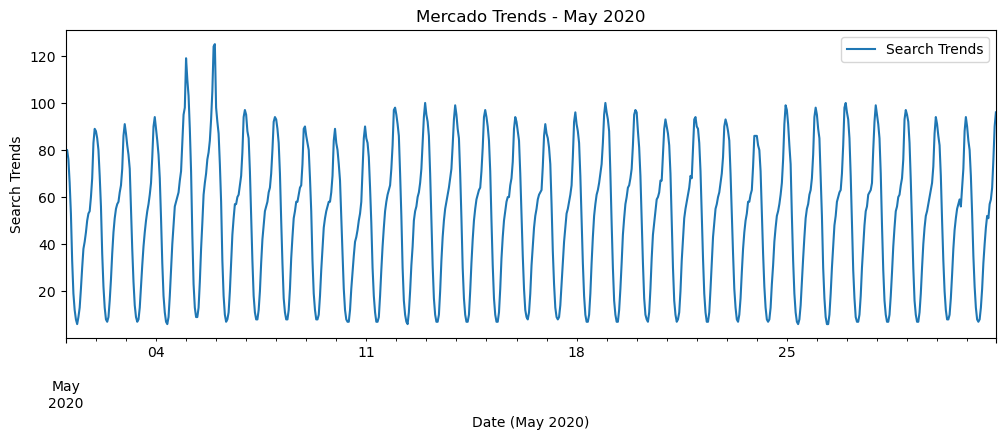

In [43]:
# Slice the DataFrame to just the month of May 2020

df_mercado_trends_may = df_mercado_trends.loc['2020-05-01':'2020-05-31', :]

# Plot to visualize the data for May 2020
import matplotlib.pyplot as plt
plt.clf()
df_mercado_trends_may.plot(figsize=(12, 4), xlabel='Date (May 2020)', ylabel='Search Trends', title='Mercado Trends - May 2020')
plt.show()


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [44]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_mercado_trends_may['Search Trends'].sum()

# View the traffic_may_2020 value
print(f'Total Search Trends for May 2020 - {traffic_may_2020}')

Total Search Trends for May 2020 - 38181


In [45]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = df_mercado_trends.groupby([df_mercado_trends.index.year, df_mercado_trends.index.month]).sum().median()

# View the median_monthly_traffic value
median_monthly_traffic

Search Trends    35172.5
dtype: float64

In [46]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
traffic_may_2020/median_monthly_traffic

Search Trends    1.085536
dtype: float64

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes, the Google search traffic increased during the month of May, as well as June. In fact, June was a bit higher. May 2020 was 8.6% higher than the overall monthly median value. 

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

,Search Trends
Date,
0,90.0
1,86.0
2,77.0
3,62.0
4,43.0
5,26.0
6,14.0
7,8.0
8,6.0


<Figure size 640x480 with 0 Axes>

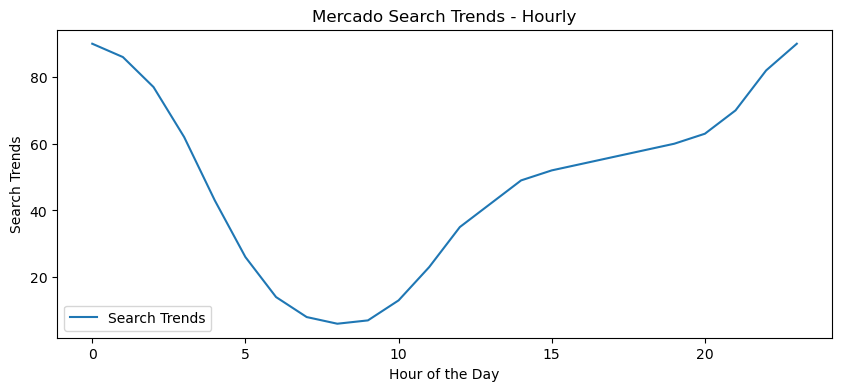

In [47]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
median_hourly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.hour).median()
display(median_hourly_traffic)

# Let's plot median_hourly_traffic
plt.clf()
median_hourly_traffic.plot(figsize=(10, 4), xlabel='Hour of the Day', ylabel='Search Trends', title='Mercado Search Trends - Hourly')
plt.show()


#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

<Figure size 640x480 with 0 Axes>

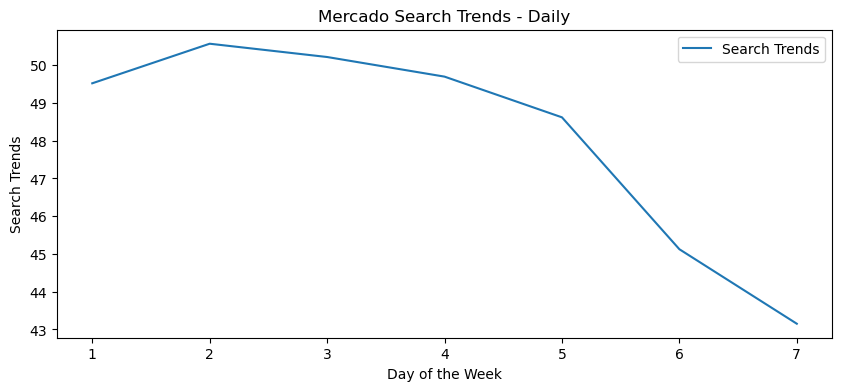

In [48]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
median_daily_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day).mean()

# Let's plot the results
plt.clf()
median_daily_traffic.plot(figsize=(10, 4), xlabel='Day of the Week', ylabel='Search Trends', title='Mercado Search Trends - Daily')
plt.show()

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

<Figure size 640x480 with 0 Axes>

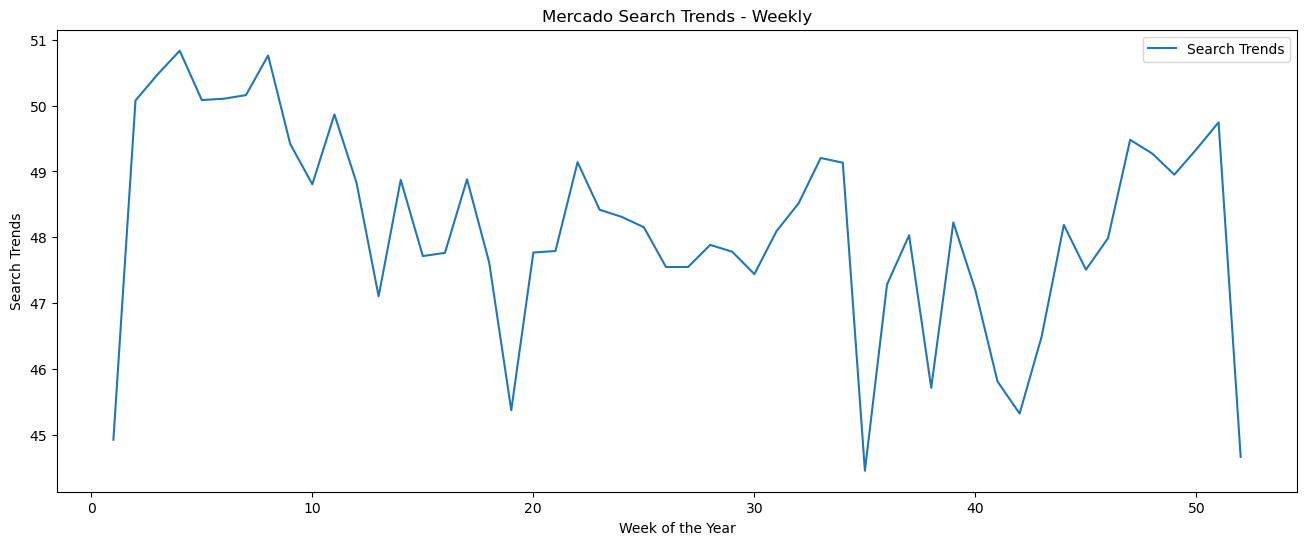

In [49]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
median_weekly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week).mean()

# Plot the search traffic by the week of the year.
plt.clf()
median_weekly_traffic.plot(figsize=(16, 6), xlabel='Week of the Year', ylabel='Search Trends', title='Mercado Search Trends - Weekly')
plt.show()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** It's interesting to note that the search trends by hour has its peaks during the late evening and early morning around 12am. People are most active during the night and early morning hours. The lowest are the morning hours around 8 and 9am. It would be interesting to know what time zone the data is collected in and what part of the world.

As far as daily, search trends are more in the beginning of the week Monday and Tuesday and drop as the week goes on. So activity happens more in the beginning of the week and drops as the week goes on.

Looking at the weekly trends, the first quarter of the year (Jan - Mar) tends to be more active. The average search trends tend to jump up and down quite a bit so it suggests there's a cycle from week to week, probably from the cycle of marketing pushes. Around Week 19 and week 36 of the year, tends to be the lowest which might signify a transition period. As the year goes into Q4, the search trends pick up which suggests there's some seasonality to search trends.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [50]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


<Figure size 640x480 with 0 Axes>

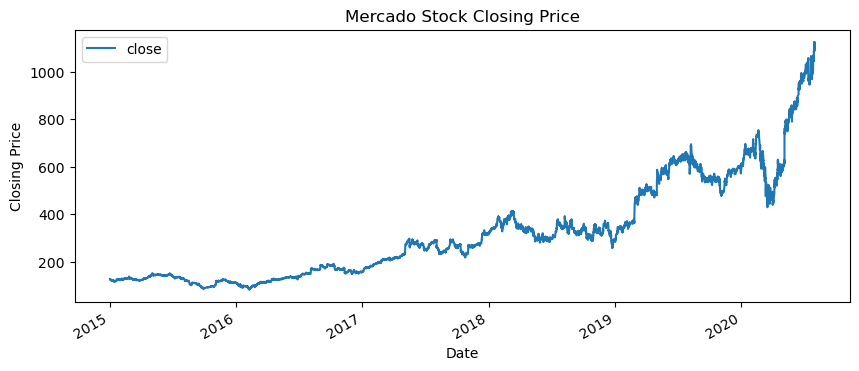

In [51]:
# Visualize the closing price of the df_mercado_stock DataFrame
plt.clf()
df_mercado_stock.plot(figsize=(10,4), title='Mercado Stock Closing Price', xlabel='Date', ylabel='Closing Price')
plt.show()

In [52]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
mercado_stock_trends_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# View the first and last five rows of the DataFrame
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())

,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [53]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
df_merged_slice_2020_first_half = mercado_stock_trends_df.loc['2020-01-01':'2020-06-30']

# View the first and last five rows of first_half_2020 DataFrame
display(df_merged_slice_2020_first_half.head())
display(df_merged_slice_2020_first_half.tail())


,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


<Figure size 640x480 with 0 Axes>

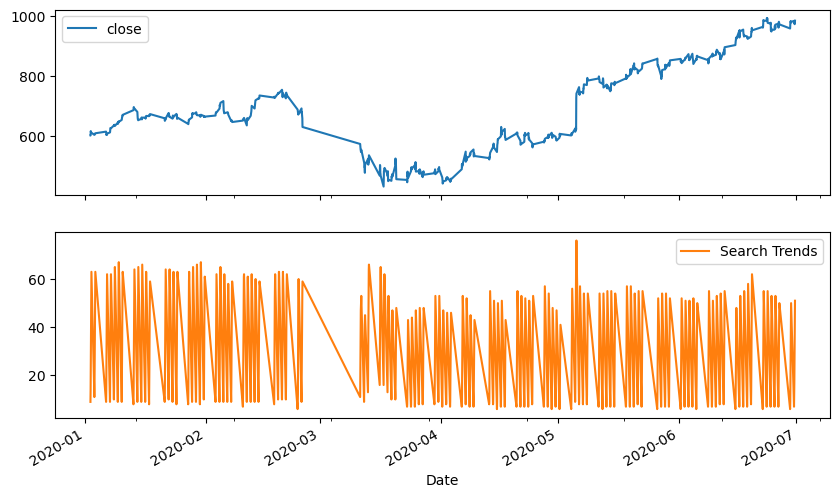

In [54]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
plt.clf()
df_merged_slice_2020_first_half.plot(subplots=True, xlabel='Date', figsize=(10,6))
plt.show()


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** Yes, both time series indicate a common trend with the narrative of there being a shock to global financial markets. This was more likely the announcement by the World Health Organization in March 2020 that COVID-19 became a global health emergency. This caused mass shutdowns of businesses and reactively, increased business in e-commerce. People were at home more and that meant shopping from home more.

Looking at the closing stock prices, the steep decline reflects this event around March 2020. We see a search trend spike as in March signifying people were at home more making more searches for items to buy.

Also notable is the spike in search trends as well as a jump in the stock closing price around May 2020. This is more than likely due to businesses acclimating to the new trends and rules with e-commerce as businesses adapted to meet market needs. Businesses that were successful in adapting did well with e-commerce which explains the recovery of the stock closing price.

As time went on, businesses that adapted became better, increasing their value of the goods and services.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [55]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)
    

In [56]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()

# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['Hourly Stock Return'].rolling(window=4).std()

<Figure size 640x480 with 0 Axes>

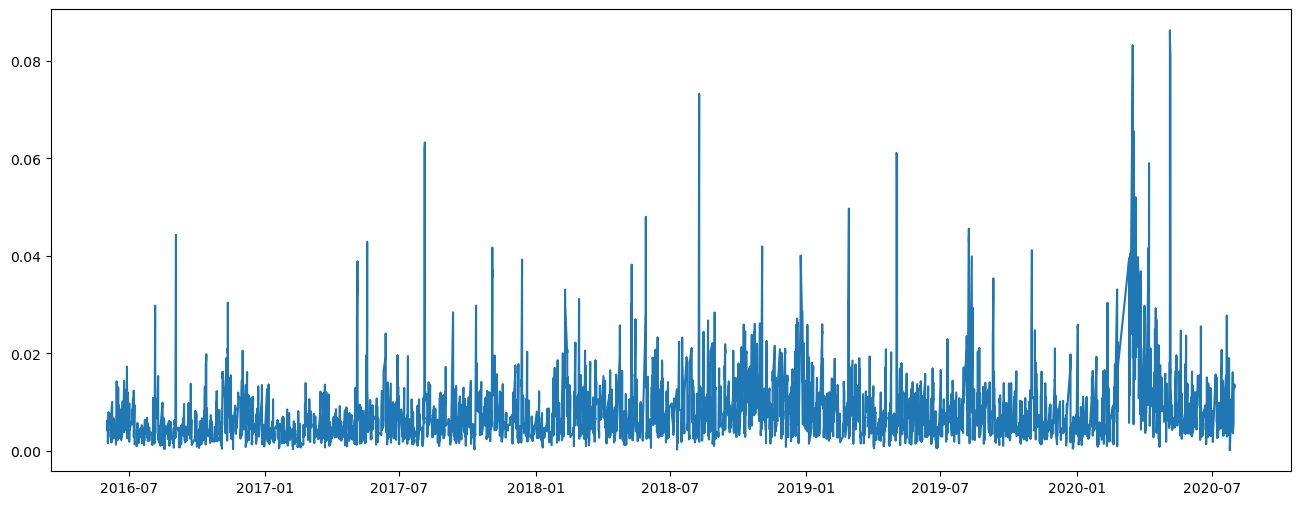

In [57]:
# Visualize the stock volatility
plt.clf()
plt.figure(figsize=(16,6))
plt.plot(mercado_stock_trends_df['Stock Volatility'])
plt.show()


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [58]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())

,close,Search Trends,Lagged Search Trends,Hourly Stock Return,Stock Volatility
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,0.010876,NaN
2016-06-01 11:00:00,136.56,22.0,12.0,-0.000512,NaN
2016-06-01 12:00:00,136.42,33.0,22.0,-0.001025,NaN
2016-06-01 13:00:00,136.10,40.0,33.0,-0.002346,0.006134


,close,Search Trends,Lagged Search Trends,Hourly Stock Return,Stock Volatility
2020-07-31 11:00:00,1105.780,20.0,11.0,0.006380,0.012837
2020-07-31 12:00:00,1087.925,32.0,20.0,-0.016147,0.013549
2020-07-31 13:00:00,1095.800,41.0,32.0,0.007239,0.013295
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013552,0.013001
2020-07-31 15:00:00,1122.510,53.0,47.0,0.010678,0.013566


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [59]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** Looking at the pairwise correlation table above, there's a weak negative correlation between the Lagged Search Trends and Stock Volatility of about 14.8% or in other words, as Lagged Search Trends increase, the Stock Volatility goes down slightly and vice versa. 

With Lagged search traffic and Hourly stock return, the correlation seems to be close to zero with a positive correlation value of 1.8%. We can probably say the correlation is 0 or no correlation.

Similarly, there is either a weak correlation or none with Hourly Stock Return and Stock Volatility and Lagged Search Trends. 

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [60]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
mercado_prophet_df = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
mercado_prophet_df.columns = ["ds", "y"]

# Drop an NaN values from the prophet_df DataFrame
mercado_prophet_df.dropna(inplace=True)

# View the first and last five rows of the mercado_prophet_df DataFrame
display(mercado_prophet_df.head())
display(mercado_prophet_df.tail())


,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [61]:
# Call the Prophet function, store as an object
m = Prophet()
m

In [62]:
# Fit the time-series model.
m.fit(mercado_prophet_df)

15:13:01 - cmdstanpy - INFO - Chain [1] start processing
15:13:11 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = m.make_future_dataframe(periods=2000, freq='h')

# View the last five rows of the future_mercado_trends DataFrame
display(future_mercado_trends.head())
display(future_mercado_trends.tail())


,ds
0,2016-06-01 00:00:00
1,2016-06-01 01:00:00
2,2016-06-01 02:00:00
3,2016-06-01 03:00:00
4,2016-06-01 04:00:00


,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [64]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = m.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
display(forecast_mercado_trends.head())


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.129250,81.131892,98.183930,44.129250,44.129250,45.429305,45.429305,45.429305,41.452726,...,1.860133,1.860133,1.860133,2.116445,2.116445,2.116445,0.0,0.0,0.0,89.558555
1,2016-06-01 01:00:00,44.130313,77.252962,94.388693,44.130313,44.130313,41.875073,41.875073,41.875073,37.943506,...,1.810049,1.810049,1.810049,2.121518,2.121518,2.121518,0.0,0.0,0.0,86.005386
2,2016-06-01 02:00:00,44.131375,67.361377,84.518398,44.131375,44.131375,31.551566,31.551566,31.551566,27.656533,...,1.768474,1.768474,1.768474,2.126559,2.126559,2.126559,0.0,0.0,0.0,75.682942
3,2016-06-01 03:00:00,44.132438,51.884715,68.632521,44.132438,44.132438,16.284352,16.284352,16.284352,12.417280,...,1.735502,1.735502,1.735502,2.131569,2.131569,2.131569,0.0,0.0,0.0,60.416789
4,2016-06-01 04:00:00,44.133500,35.143118,51.726845,44.133500,44.133500,-0.830504,-0.830504,-0.830504,-4.678139,...,1.711088,1.711088,1.711088,2.136547,2.136547,2.136547,0.0,0.0,0.0,43.302997


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

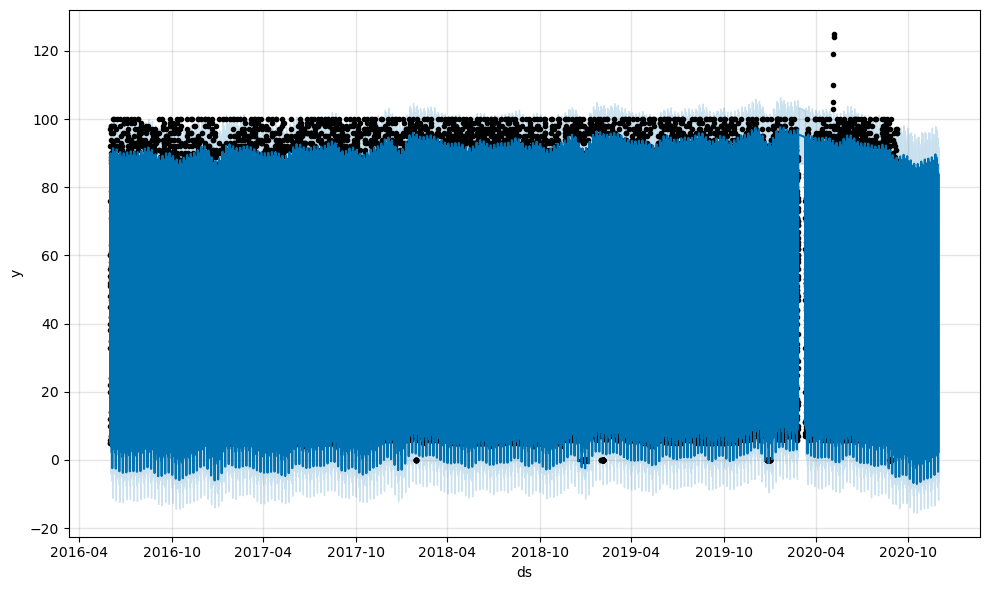

In [65]:
# Plot the Prophet predictions for the Mercado trends data
m.plot(forecast_mercado_trends)

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** Looking at the plot above, the black dots represent the empirical data we have. Looking past that where the lighter shade of blue represents the upper range (yhat_upper) and the dark blue represents the lower range (yhat_upper). Giving the trend of these ranges, it seems to drop around 2020-10 and then on, increases slightly.

Interpreting this, the popularity is predicted to fall for a bit and slowly rise again given its cyclical nature.

#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [66]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends = forecast_mercado_trends.set_index("ds")

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast_mercado_trends[["yhat", "yhat_lower", "yhat_upper"]].head()


,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.558555,81.131892,98.183930
2016-06-01 01:00:00,86.005386,77.252962,94.388693
2016-06-01 02:00:00,75.682942,67.361377,84.518398
2016-06-01 03:00:00,60.416789,51.884715,68.632521
2016-06-01 04:00:00,43.302997,35.143118,51.726845


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

<Figure size 1000x600 with 0 Axes>

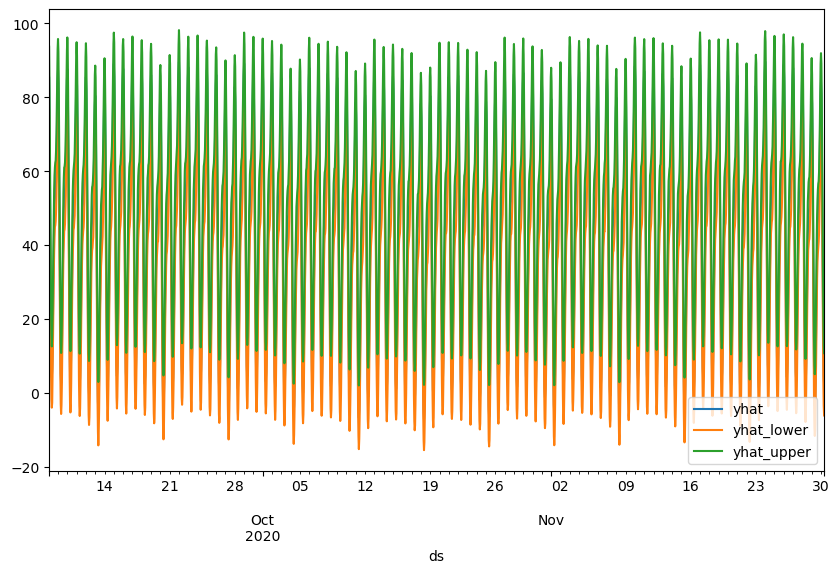

In [67]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
plt.clf()
forecast_mercado_trends[["yhat", "yhat_lower", "yhat_upper"]].iloc[-2000:,:].plot(figsize=(10,6))
plt.show()



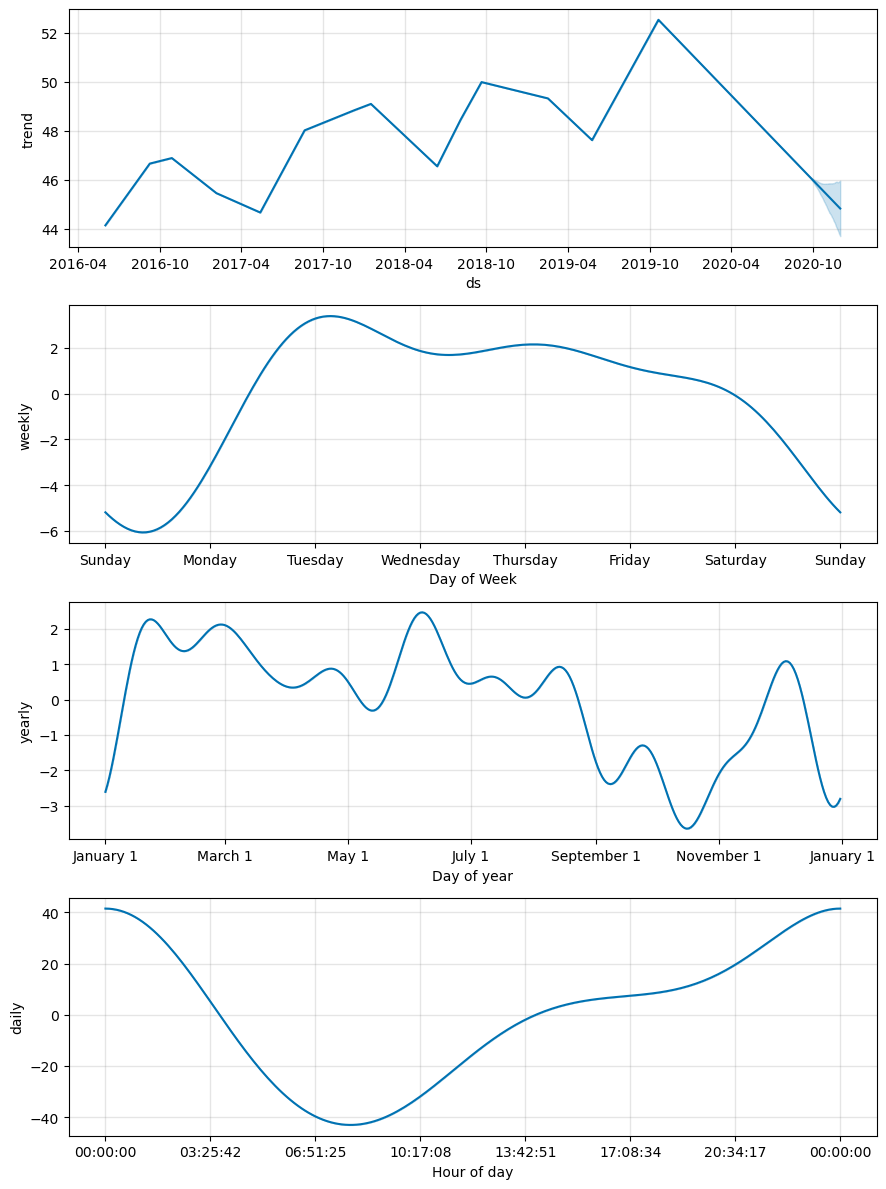

In [68]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends = forecast_mercado_trends.reset_index()
forecast_mercado_trends.head()

# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
m.plot_components(forecast_mercado_trends)

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** Popularity peaks around 12:00am or 0H:00M. 

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Tuesday

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** Sometime between September 15th an November 1st. Roughly around September 15th. 
